In [1]:
import matplotlib.pyplot as plt
import os, re, pickle,tqdm
import scipy.io
from collections import defaultdict
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def nested_dict(n):
    if n == 1:
        return defaultdict(lambda: np.ndarray(0))
    else:
        return defaultdict(lambda: nested_dict(n-1))
    
color_code = {
    "DET vs FullGradCam":       "blue",
    "DET-GrpF vs FullGradCam":  "#0072BD",
    "DET-GrpE vs FullGradCam":  "cyan",
    
    "EXP vs ODAM":              "red",
    "EXP-GrpF vs ODAM":         "orange",
    "EXP-GrpE vs ODAM":         "olive",

    "PV vs FullGradCam":        "purple",
    "PV-GrpF vs FullGradCam":   "pink",
    "PV-GrpE vs FullGradCam":   "magenta",
}

tnrfont = {'fontname':'Times New Roman'}

alpha = 0.3

### Whole-Image Human Attention Maps
For the definition of Explorative vs Focused groups, see Mary's results at:
https://docs.google.com/presentation/d/1b7mX8MR4Q-D1JT0DY1LpjvM6y8iggoAdjS_4Vv8sNag/edit

In [2]:
human_attention_path = {
    "DET":'/mnt/h/OneDrive - The University Of Hong Kong/mscoco/attention_maps/240107_DET_excluded_resized/attention_maps',
    "DET-GrpF":'/mnt/h/OneDrive - The University Of Hong Kong/mscoco/attention_maps/240107_DET_excluded_resized/grp2',
    "DET-GrpE":'/mnt/h/OneDrive - The University Of Hong Kong/mscoco/attention_maps/240107_DET_excluded_resized/grp1',
    "EXP":'/mnt/h/OneDrive - The University Of Hong Kong/mscoco/attention_maps/231222_EXP_excluded_cleaned_resized/attention_maps',
    "EXP-GrpF":'/mnt/h/OneDrive - The University Of Hong Kong/mscoco/attention_maps/231222_EXP_excluded_cleaned_resized/grp2',
    "EXP-GrpE":'/mnt/h/OneDrive - The University Of Hong Kong/mscoco/attention_maps/231222_EXP_excluded_cleaned_resized/grp1',
    "PV":'/mnt/h/OneDrive - The University Of Hong Kong/mscoco/attention_maps/231221_PV_resized/attention_maps',
    "PV-GrpF":'/mnt/h/OneDrive - The University Of Hong Kong/mscoco/attention_maps/231221_PV_resized/grp2',
    "PV-GrpE":'/mnt/h/OneDrive - The University Of Hong Kong/mscoco/attention_maps/231221_PV_resized/grp1',
}

# Attention Type, Image Idex
human_attention = {
    "DET":defaultdict(),
    "DET-GrpF":defaultdict(),
    "DET-GrpE":defaultdict(),
    "EXP":defaultdict(),
    "EXP-GrpF":defaultdict(),
    "EXP-GrpE":defaultdict(),
    "PV":defaultdict(),
    "PV-GrpF":defaultdict(),
    "PV-GrpE":defaultdict(),
}

for type, path_by_type in human_attention_path.items():
    for file in os.listdir(path_by_type):
        img_idx = file.replace('_GSmo_21.mat','')
        mat = scipy.io.loadmat(os.path.join(path_by_type,file))
        human_attention[type][img_idx] = mat['output_map_norm']

In [3]:
for type, t in human_attention.items():
    print(f"{type} {len(t)}")
    for img in t:
        if img not in human_attention['DET'].keys():
            print(img)

DET 160
DET-GrpF 160
DET-GrpE 160
EXP 160
EXP-GrpF 160
EXP-GrpE 160
PV 160
PV-GrpF 160
PV-GrpE 160


In [5]:
failed_imgs = {
    "FullGradCAM":defaultdict(list),
    "ODAM":defaultdict(list),
}

In [2]:
layer_name_mapping = [
    'backbone.res2.0.conv1',
    'backbone.res2.0.conv2',
    'backbone.res2.0.conv3',
    'backbone.res2.1.conv1',
    'backbone.res2.1.conv2',
    'backbone.res2.1.conv3',
    'backbone.res2.2.conv1',
    'backbone.res2.2.conv2',
    'backbone.res2.2.conv3',
    'backbone.res3.0.conv1',
    'backbone.res3.0.conv2',
    'backbone.res3.0.conv3',
    'backbone.res3.1.conv1',
    'backbone.res3.1.conv2',
    'backbone.res3.1.conv3',
    'backbone.res3.2.conv1',
    'backbone.res3.2.conv2',
    'backbone.res3.2.conv3',
    'backbone.res3.3.conv1',
    'backbone.res3.3.conv2',
    'backbone.res3.3.conv3',
    'backbone.res4.0.conv1',
    'backbone.res4.0.conv2',
    'backbone.res4.0.conv3',
    'backbone.res4.1.conv1',
    'backbone.res4.1.conv2',
    'backbone.res4.1.conv3',
    'backbone.res4.2.conv1',
    'backbone.res4.2.conv2',
    'backbone.res4.2.conv3',
    'backbone.res4.3.conv1',
    'backbone.res4.3.conv2',
    'backbone.res4.3.conv3',
    'backbone.res4.4.conv1',
    'backbone.res4.4.conv2',
    'backbone.res4.4.conv3',
    'backbone.res4.5.conv1',
    'backbone.res4.5.conv2',
    'backbone.res4.5.conv3',

    #ROI
    'roi_heads.pooler.level_poolers.0',
    'roi_heads.res5.0.conv1',
    'roi_heads.res5.0.conv2',
    'roi_heads.res5.0.conv3',
    'roi_heads.res5.1.conv1',
    'roi_heads.res5.1.conv2',
    'roi_heads.res5.1.conv3',
    'roi_heads.res5.2.conv1',
    'roi_heads.res5.2.conv2',
    'roi_heads.res5.2.conv3',
]

In [14]:
xai_saliency_path = {
    "FullGradCAM":'/mnt/h/jinhan/results/mscoco/xai_saliency_maps_faster_gaussian_sigma4/fullgradcamraw',
    "ODAM":'/mnt/h/jinhan/results/mscoco/xai_saliency_maps_faster_gaussian_sigma4/odam',
}

# Type, Category, Layer, Image
xai_saliency_maps = {
    "FullGradCAM":defaultdict(defaultdict),
    "ODAM":defaultdict(defaultdict),
}

for type, path_by_type in xai_saliency_path.items():
    for dir in tqdm.tqdm(os.listdir(path_by_type)):
        layer_name = None
        if '.mat' in dir: continue # skip faithfulness data
        for l in layer_name_mapping:
            if l in dir:
                layer_name = l
                break
        if not layer_name:
            print(f"NOT FOUND! {dir}")
            continue
        # layer_num = int(re.findall(r"F\d+",dir)[-1].replace('F',''))

        for file in os.listdir(os.path.join(path_by_type,dir)):
            if '.mat' not in file: continue
            img_idx = file.replace('-res.png.mat','')
            try:
                mat = io.loadmat(os.path.join(path_by_type,dir,file))
                if mat['masks_ndarray'].sum()==1.5 and mat['masks_ndarray'][0,0]==1 and mat['masks_ndarray'][1,1]==0.5:
                    failed_imgs[type][layer_name].append(img_idx)
                    continue
                elif not np.any(mat['masks_ndarray']):
                    failed_imgs[type][layer_name].append(img_idx)
                    continue
                elif np.any(np.isnan(mat['masks_ndarray'])):
                    failed_imgs[type][layer_name].append(img_idx)
                    continue
                xai_saliency_maps[type][layer_name][img_idx] = mat['masks_ndarray']
            except:
                print(f"{type}\t{layer_name}\t{file}")

  0%|          | 0/98 [00:00<?, ?it/s]

100%|██████████| 49/49 [09:45<00:00, 11.96s/it]


In [10]:
xai_saliency_maps['ODAM']['backbone.res4.1.conv3']['kite_405279'] = scipy.io.loadmat(os.path.join('/mnt/h/OneDrive - The University Of Hong Kong/mscoco/xai_saliency_maps_faster/odam','odam_NMS_class_backbone.res4.1.conv3_singleScale_norm_model_final_721ade','kite_405279-res.png.mat'))['masks_ndarray']

In [13]:
xai_saliency_maps['ODAM']['backbone.res4.1.conv3']['kite_405279'].min()

0.0

In [15]:
for category, c in failed_imgs.items():
    print(category)
    for layer,l in c.items():
        print(f"{layer} {len(l)} {l}")

FullGradCAM
ODAM


In [82]:
skipped = [] #['book_472678', 'hair drier_178028', 'hair drier_239041', 'kite_405279', 'mouse_513688', 'toaster_232348', 'toaster_453302', 'toothbrush_218439', 'traffic light_453841']

for type, path_by_type in xai_saliency_path.items():
    for dir in os.listdir(path_by_type):
        for l in layer_name_mapping:
            if l in dir:
                failed = set(failed_imgs[type][l]) - set(skipped)
                if len(failed)>0: print(f"{type} {dir} {len(failed)}")
                for img in failed:
                    print(img)
                    os.remove(os.path.join(path_by_type,dir,f'{img}-res.png'))
                    os.remove(os.path.join(path_by_type,dir,f'{img}-res.png.mat'))

FullGradCAM fullgradcamraw_NMS_class_backbone.res2.0.conv1_singleScale_norm_model_final_721ade 6
toaster_232348
toothbrush_218439
hair drier_239041
hair drier_178028
pizza_294831
toaster_453302
FullGradCAM fullgradcamraw_NMS_class_backbone.res2.0.conv2_singleScale_norm_model_final_721ade 5
toaster_232348
toothbrush_218439
hair drier_239041
hair drier_178028
toaster_453302
FullGradCAM fullgradcamraw_NMS_class_backbone.res2.0.conv3_singleScale_norm_model_final_721ade 5
toaster_232348
toothbrush_218439
hair drier_239041
hair drier_178028
toaster_453302
FullGradCAM fullgradcamraw_NMS_class_backbone.res2.1.conv1_singleScale_norm_model_final_721ade 6
toaster_232348
toothbrush_218439
hair drier_239041
hair drier_178028
sports ball_60102
toaster_453302
FullGradCAM fullgradcamraw_NMS_class_backbone.res2.1.conv2_singleScale_norm_model_final_721ade 5
toaster_232348
toothbrush_218439
hair drier_239041
hair drier_178028
toaster_453302
FullGradCAM fullgradcamraw_NMS_class_backbone.res2.1.conv3_singl

In [17]:
all_failed_imgs = set()
for category, c in failed_imgs.items():
    for layer, l in c.items():
        for img in l:
            all_failed_imgs.add(img)

for img in ['book_472678','clock_164363','hair drier_178028','hair drier_239041', 'kite_405279', 'mouse_513688', 'toaster_232348', 'toaster_453302', 'toothbrush_218439', 'traffic light_453841']:
    all_failed_imgs.add(img)
all_failed_imgs

{'book_472678',
 'clock_164363',
 'hair drier_178028',
 'hair drier_239041',
 'kite_405279',
 'mouse_513688',
 'toaster_232348',
 'toaster_453302',
 'toothbrush_218439',
 'traffic light_453841'}

In [77]:
np.all(np.isnan(xai_saliency_maps['FullGradCAM']['backbone.res2.2.conv2']['apple_562059']))

False

In [48]:
for type, t in xai_saliency_maps.items():
        for layer, l in t.items():
                print(f"{type} Layer {layer} {len(l)}")
                for img in l:
                        if img not in human_attention['DET']: print(img)

FullGradCAM Layer backbone.res2.0.conv1 160
FullGradCAM Layer backbone.res2.0.conv2 160
FullGradCAM Layer backbone.res2.0.conv3 160
FullGradCAM Layer backbone.res2.1.conv1 160
FullGradCAM Layer backbone.res2.1.conv2 160
FullGradCAM Layer backbone.res2.1.conv3 160
FullGradCAM Layer backbone.res2.2.conv1 160
FullGradCAM Layer backbone.res2.2.conv2 160
FullGradCAM Layer backbone.res2.2.conv3 160
FullGradCAM Layer backbone.res3.0.conv1 160
FullGradCAM Layer backbone.res3.0.conv2 160
FullGradCAM Layer backbone.res3.0.conv3 160
FullGradCAM Layer backbone.res3.1.conv1 160
FullGradCAM Layer backbone.res3.1.conv2 160
FullGradCAM Layer backbone.res3.1.conv3 160
FullGradCAM Layer backbone.res3.2.conv1 160
FullGradCAM Layer backbone.res3.2.conv2 160
FullGradCAM Layer backbone.res3.2.conv3 160
FullGradCAM Layer backbone.res3.3.conv1 160
FullGradCAM Layer backbone.res3.3.conv2 160
FullGradCAM Layer backbone.res3.3.conv3 160
FullGradCAM Layer backbone.res4.0.conv1 160
FullGradCAM Layer backbone.res4.

## Similarity Analysis

In [18]:
zero_pcc = {
    "DET vs FullGradCam":defaultdict(list),
    "DET-GrpF vs FullGradCam":defaultdict(list),
    "DET-GrpE vs FullGradCam":defaultdict(list),
    "EXP vs ODAM":defaultdict(list),
    "EXP-GrpF vs ODAM":defaultdict(list),
    "EXP-GrpE vs ODAM":defaultdict(list),
    "PV vs FullGradCam":defaultdict(list),
    "PV-GrpF vs FullGradCam":defaultdict(list),
    "PV-GrpE vs FullGradCam":defaultdict(list),
}

negative_pcc = {
    "DET vs FullGradCam":defaultdict(list),
    "DET-GrpF vs FullGradCam":defaultdict(list),
    "DET-GrpE vs FullGradCam":defaultdict(list),
    "EXP vs ODAM":defaultdict(list),
    "EXP-GrpF vs ODAM":defaultdict(list),
    "EXP-GrpE vs ODAM":defaultdict(list),
    "PV vs FullGradCam":defaultdict(list),
    "PV-GrpF vs FullGradCam":defaultdict(list),
    "PV-GrpE vs FullGradCam":defaultdict(list),
}

In [19]:
PCC_all = {
    "DET vs FullGradCam":defaultdict(defaultdict),
    "DET-GrpF vs FullGradCam":defaultdict(defaultdict),
    "DET-GrpE vs FullGradCam":defaultdict(defaultdict),
    "EXP vs ODAM":defaultdict(defaultdict),
    "EXP-GrpF vs ODAM":defaultdict(defaultdict),
    "EXP-GrpE vs ODAM":defaultdict(defaultdict),
    "PV vs FullGradCam":defaultdict(defaultdict),
    "PV-GrpF vs FullGradCam":defaultdict(defaultdict),
    "PV-GrpE vs FullGradCam":defaultdict(defaultdict),
}
RMSE_all = {
    "DET vs FullGradCam":defaultdict(defaultdict),
    "DET-GrpF vs FullGradCam":defaultdict(defaultdict),
    "DET-GrpE vs FullGradCam":defaultdict(defaultdict),
    "EXP vs ODAM":defaultdict(defaultdict),
    "EXP-GrpF vs ODAM":defaultdict(defaultdict),
    "EXP-GrpE vs ODAM":defaultdict(defaultdict),
    "PV vs FullGradCam":defaultdict(defaultdict),
    "PV-GrpF vs FullGradCam":defaultdict(defaultdict),
    "PV-GrpE vs FullGradCam":defaultdict(defaultdict),
}

for layer in layer_name_mapping:
    for img in human_attention['DET'].keys():
        if img in all_failed_imgs: continue

        if img in xai_saliency_maps['FullGradCAM'][layer].keys():
            # DET vs FullGradCam
            PCC_all['DET vs FullGradCam'][layer][img] = np.corrcoef(xai_saliency_maps['FullGradCAM'][layer][img].flatten(), human_attention['DET'][img].flatten())[0,1]
            RMSE_all['DET vs FullGradCam'][layer][img] = RMSE(xai_saliency_maps['FullGradCAM'][layer][img].flatten(), human_attention['DET'][img].flatten())
            if PCC_all['DET vs FullGradCam'][layer][img] == 0:
                zero_pcc['DET vs FullGradCam'][layer].append(img)
            elif PCC_all['DET vs FullGradCam'][layer][img] < 0:
                negative_pcc['DET vs FullGradCam'][layer].append(img)

            # DET-GrpF vs FullGradCam
            PCC_all['DET-GrpF vs FullGradCam'][layer][img] = np.corrcoef(xai_saliency_maps['FullGradCAM'][layer][img].flatten(), human_attention['DET-GrpF'][img].flatten())[0,1]
            RMSE_all['DET-GrpF vs FullGradCam'][layer][img] = RMSE(xai_saliency_maps['FullGradCAM'][layer][img].flatten(), human_attention['DET-GrpF'][img].flatten())
            if PCC_all['DET-GrpF vs FullGradCam'][layer][img] == 0:
                zero_pcc['DET-GrpF vs FullGradCam'][layer].append(img)
            elif PCC_all['DET-GrpF vs FullGradCam'][layer][img] < 0:
                negative_pcc['DET-GrpF vs FullGradCam'][layer].append(img)

            # DET-GrpE vs FullGradCam
            PCC_all['DET-GrpE vs FullGradCam'][layer][img] = np.corrcoef(xai_saliency_maps['FullGradCAM'][layer][img].flatten(), human_attention['DET-GrpE'][img].flatten())[0,1]
            RMSE_all['DET-GrpE vs FullGradCam'][layer][img] = RMSE(xai_saliency_maps['FullGradCAM'][layer][img].flatten(), human_attention['DET-GrpE'][img].flatten())
            if PCC_all['DET-GrpE vs FullGradCam'][layer][img] == 0:
                zero_pcc['DET-GrpE vs FullGradCam'][layer].append(img)
            elif PCC_all['DET-GrpE vs FullGradCam'][layer][img] < 0:
                negative_pcc['DET-GrpE vs FullGradCam'][layer].append(img)

            # PV vs FullGradCam
            PCC_all['PV vs FullGradCam'][layer][img] = np.corrcoef(xai_saliency_maps['FullGradCAM'][layer][img].flatten(), human_attention['PV'][img].flatten())[0,1]
            RMSE_all['PV vs FullGradCam'][layer][img] = RMSE(xai_saliency_maps['FullGradCAM'][layer][img].flatten(), human_attention['PV'][img].flatten())
            if PCC_all['PV vs FullGradCam'][layer][img] == 0:
                zero_pcc['PV vs FullGradCam'][layer].append(img)
            elif PCC_all['PV vs FullGradCam'][layer][img] < 0:
                negative_pcc['PV vs FullGradCam'][layer].append(img)

            # PV-GrpF vs FullGradCam
            PCC_all['PV-GrpF vs FullGradCam'][layer][img] = np.corrcoef(xai_saliency_maps['FullGradCAM'][layer][img].flatten(), human_attention['PV-GrpF'][img].flatten())[0,1]
            RMSE_all['PV-GrpF vs FullGradCam'][layer][img] = RMSE(xai_saliency_maps['FullGradCAM'][layer][img].flatten(), human_attention['PV-GrpF'][img].flatten())
            if PCC_all['PV-GrpF vs FullGradCam'][layer][img] == 0:
                zero_pcc['PV-GrpF vs FullGradCam'][layer].append(img)
            elif PCC_all['PV-GrpF vs FullGradCam'][layer][img] < 0:
                negative_pcc['PV-GrpF vs FullGradCam'][layer].append(img)

            # PV-GrpE vs FullGradCam
            PCC_all['PV-GrpE vs FullGradCam'][layer][img] = np.corrcoef(xai_saliency_maps['FullGradCAM'][layer][img].flatten(), human_attention['PV-GrpE'][img].flatten())[0,1]
            RMSE_all['PV-GrpE vs FullGradCam'][layer][img] = RMSE(xai_saliency_maps['FullGradCAM'][layer][img].flatten(), human_attention['PV-GrpE'][img].flatten())
            if PCC_all['PV-GrpE vs FullGradCam'][layer][img] == 0:
                zero_pcc['PV-GrpE vs FullGradCam'][layer].append(img)
            elif PCC_all['PV-GrpE vs FullGradCam'][layer][img] < 0:
                negative_pcc['PV-GrpE vs FullGradCam'][layer].append(img)

        if img in xai_saliency_maps['ODAM'][layer].keys():
            # EXP vs ODAM
            PCC_all['EXP vs ODAM'][layer][img] = np.corrcoef(xai_saliency_maps['ODAM'][layer][img].flatten(), human_attention['EXP'][img].flatten())[0,1]
            RMSE_all['EXP vs ODAM'][layer][img] = RMSE(xai_saliency_maps['ODAM'][layer][img].flatten(), human_attention['EXP'][img].flatten())
            if PCC_all['EXP vs ODAM'][layer][img] == 0:
                zero_pcc['EXP vs ODAM'][layer].append(img)
            elif PCC_all['EXP vs ODAM'][layer][img] < 0:
                negative_pcc['EXP vs ODAM'][layer].append(img)

            # EXP-GrpF vs ODAM
            PCC_all['EXP-GrpF vs ODAM'][layer][img] = np.corrcoef(xai_saliency_maps['ODAM'][layer][img].flatten(), human_attention['EXP-GrpF'][img].flatten())[0,1]
            RMSE_all['EXP-GrpF vs ODAM'][layer][img] = RMSE(xai_saliency_maps['ODAM'][layer][img].flatten(), human_attention['EXP-GrpF'][img].flatten())
            if PCC_all['EXP-GrpF vs ODAM'][layer][img] == 0:
                zero_pcc['EXP-GrpF vs ODAM'][layer].append(img)
            elif PCC_all['EXP-GrpF vs ODAM'][layer][img] < 0:
                negative_pcc['EXP-GrpF vs ODAM'][layer].append(img)

            # EXP-GrpE vs ODAM
            PCC_all['EXP-GrpE vs ODAM'][layer][img] = np.corrcoef(xai_saliency_maps['ODAM'][layer][img].flatten(), human_attention['EXP-GrpE'][img].flatten())[0,1]
            RMSE_all['EXP-GrpE vs ODAM'][layer][img] = RMSE(xai_saliency_maps['ODAM'][layer][img].flatten(), human_attention['EXP-GrpE'][img].flatten())
            if PCC_all['EXP-GrpE vs ODAM'][layer][img] == 0:
                zero_pcc['EXP-GrpE vs ODAM'][layer].append(img)
            elif PCC_all['EXP-GrpE vs ODAM'][layer][img] < 0:
                negative_pcc['EXP-GrpE vs ODAM'][layer].append(img)


In [18]:
for analysis in ['DET vs FullGradCam','EXP vs ODAM','PV vs FullGradCam']:
    print(analysis)
    for layer in PCC_all[analysis]:
        print(f"Layer {layer}\t{len(PCC_all[analysis][layer])}")
        for img in set(failed_imgs):
            if img in PCC_all[analysis][layer]:
                print(img)

DET vs FullGradCam
Layer backbone.res2.0.conv1	150
Layer backbone.res2.0.conv2	150
Layer backbone.res2.0.conv3	150
Layer backbone.res2.1.conv1	150
Layer backbone.res2.1.conv2	150
Layer backbone.res2.1.conv3	150
Layer backbone.res2.2.conv1	150
Layer backbone.res2.2.conv2	150
Layer backbone.res2.2.conv3	150
Layer backbone.res3.0.conv1	150
Layer backbone.res3.0.conv2	150
Layer backbone.res3.0.conv3	150
Layer backbone.res3.1.conv1	150
Layer backbone.res3.1.conv2	150
Layer backbone.res3.1.conv3	150
Layer backbone.res3.2.conv1	150
Layer backbone.res3.2.conv2	150
Layer backbone.res3.2.conv3	150
Layer backbone.res3.3.conv1	150
Layer backbone.res3.3.conv2	150
Layer backbone.res3.3.conv3	150
Layer backbone.res4.0.conv1	150
Layer backbone.res4.0.conv2	150
Layer backbone.res4.0.conv3	150
Layer backbone.res4.1.conv1	150
Layer backbone.res4.1.conv2	150
Layer backbone.res4.1.conv3	150
Layer backbone.res4.2.conv1	150
Layer backbone.res4.2.conv2	150
Layer backbone.res4.2.conv3	150
Layer backbone.res4.3

In [19]:
for analysis in ['DET vs FullGradCam','EXP vs ODAM','PV vs FullGradCam']:
    print(analysis)
    zero_pcc_imgs = []
    negative_pcc_imgs = []
    for layer in range(1,18):
        zero_pcc_imgs += zero_pcc[analysis][layer]
        negative_pcc_imgs += negative_pcc[analysis][layer]
    print(len(set(zero_pcc_imgs)))
    print(set(zero_pcc_imgs))
    print(len(set(negative_pcc_imgs)))
    print(set(negative_pcc_imgs))

DET vs FullGradCam
0
set()
0
set()
EXP vs ODAM
0
set()
0
set()
PV vs FullGradCam
0
set()
0
set()


In [17]:
for layer in range(1,18):
    for analysis in ['DET vs FullGradCam','EXP vs ODAM','PV vs FullGradCam']:
        print(analysis)
        arr = np.asarray(list(PCC_all[analysis][layer].values()))
        max_idx = arr.argmax()
        max_value = arr[max_idx]
        min_idx = np.where(arr>0, arr, np.inf).argmin()
        min_value = arr[min_idx]
        print(f"Layer {layer}:\t{max_value} {min_value}")

DET vs FullGradCam
Layer 1:	0.5481023999586653 0.04679038993824672
EXP vs ODAM
Layer 1:	0.5354098317328723 0.024733353735554336
PV vs FullGradCam
Layer 1:	0.5391918098964178 0.0002847368694132036
DET vs FullGradCam
Layer 2:	0.4610688922759816 0.03697291962395312
EXP vs ODAM
Layer 2:	0.47134855829504263 0.025656780381159955
PV vs FullGradCam
Layer 2:	0.467960099305782 0.006126723698534344
DET vs FullGradCam
Layer 3:	0.3752328318163533 0.02221648679367458
EXP vs ODAM
Layer 3:	0.39867069274693495 0.024038150500299164
PV vs FullGradCam
Layer 3:	0.3323547341832587 0.0005676145368007569
DET vs FullGradCam
Layer 4:	0.5377877971342195 0.05199066163229023
EXP vs ODAM
Layer 4:	0.5360722419504018 0.04168691542230686
PV vs FullGradCam
Layer 4:	0.5294532804498919 0.002047358611131584
DET vs FullGradCam
Layer 5:	0.5831574848748111 0.0486837851671881
EXP vs ODAM
Layer 5:	0.5808883660673232 0.042334987168563216
PV vs FullGradCam
Layer 5:	0.5086630894156132 0.004683904326898975
DET vs FullGradCam
Layer

In [20]:
pickle.dump(PCC_all, open('/mnt/h/jinhan/xai/results/mscoco/faster_rcnn/mscoco_sigma4_PCC_all_conv.pickle','wb'))
pickle.dump(RMSE_all, open('/mnt/h/jinhan/xai/results/mscoco/faster_rcnn/mscoco_sigma4_RMSE_all_conv.pickle','wb'))

In [2]:
PCC_all = pickle.load(open('/mnt/h/jinhan/xai/results/mscoco/faster_rcnn/mscoco_sigma4_PCC_all_conv.pickle','rb'))
RMSE_all = pickle.load(open('/mnt/h/jinhan/xai/results/mscoco/faster_rcnn/mscoco_sigma4_RMSE_all_conv.pickle','rb'))

In [19]:
PCC_all['DET vs FullGradCam'].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])

In [3]:
PCC_layer_mean = defaultdict()
RMSE_layer_mean = defaultdict()

for analysis in PCC_all.keys():
    PCC_layer_mean[analysis] = pd.DataFrame.from_dict(PCC_all[analysis]).mean(axis=0)
    RMSE_layer_mean[analysis] = pd.DataFrame.from_dict(RMSE_all[analysis]).mean(axis=0)

## Plot layers

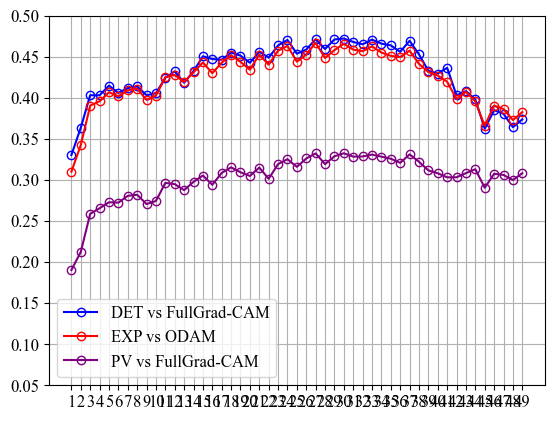

In [23]:
ylims = (0.05,0.5)

plt.figure()
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.grid()
# plt.xlabel('Layer')
# plt.ylabel('PCC')
for analysis in ['DET vs FullGradCam','EXP vs ODAM','PV vs FullGradCam']:
    plt.plot(np.arange(len(PCC_layer_mean[analysis]))+1, list(PCC_layer_mean[analysis]), marker='o',fillstyle='none',label=analysis,c=color_code[analysis])
plt.xticks(np.arange(len(PCC_layer_mean[analysis]))+1)
plt.ylim(ylims)
# plt.title(f"Yolo-v5s MSCOCO")
plt.legend(labels=['DET vs FullGrad-CAM','EXP vs ODAM','PV vs FullGrad-CAM'],fontsize=12)
plt.show()


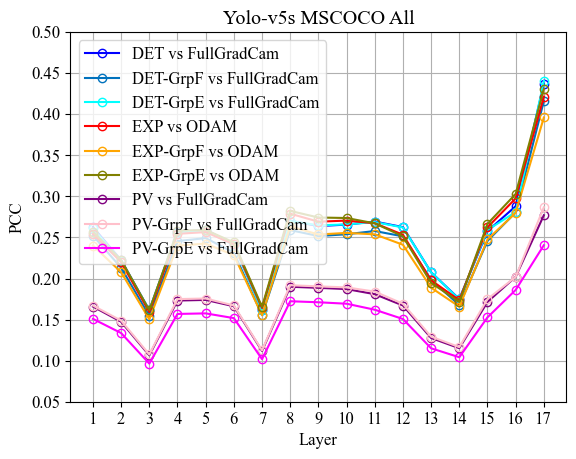

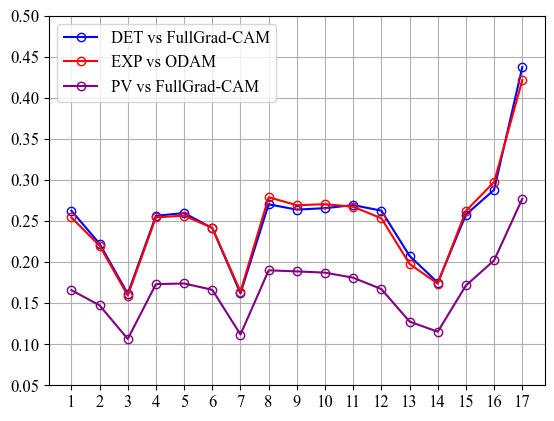

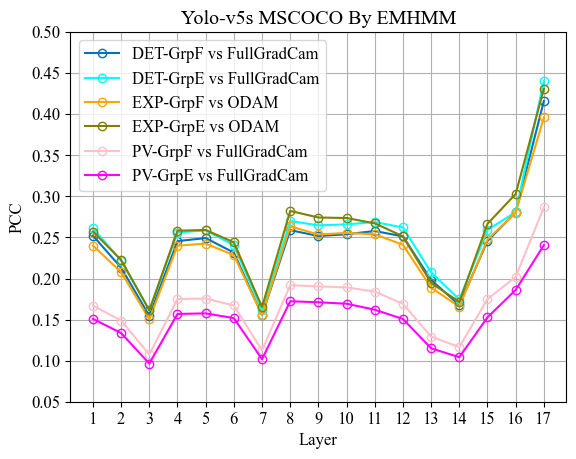

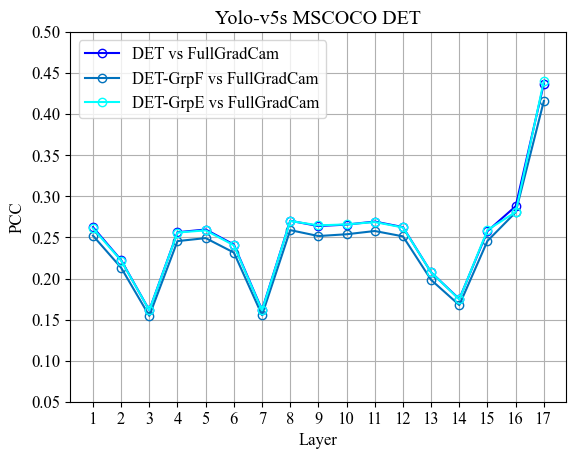

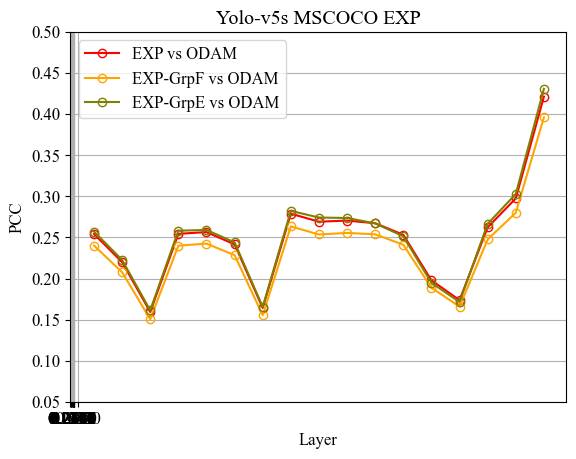

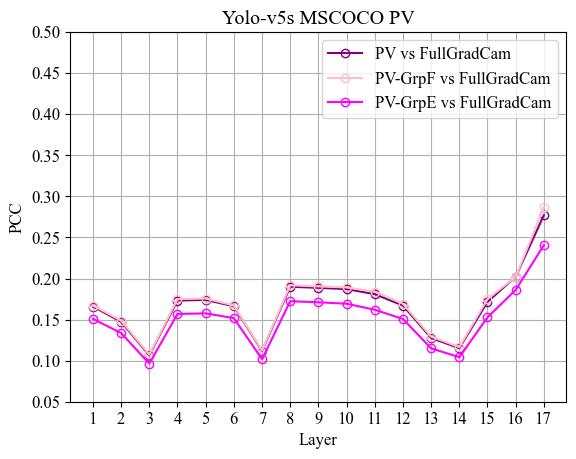

In [28]:
ylims = (0.05,0.5)

#All in one
plt.figure()
plt.grid()
plt.xlabel('Layer')
plt.ylabel('PCC')
for analysis in PCC_all.keys():
    plt.plot(np.arange(len(PCC_layer_mean[analysis]))+1, list(PCC_layer_mean[analysis]), marker='o',fillstyle='none',label=analysis,c=color_code[analysis])
plt.xticks(np.arange(len(PCC_layer_mean[analysis]))+1)
plt.ylim(ylims)
plt.title(f"Yolo-v5s MSCOCO All")
plt.legend()
plt.savefig(f'/mnt/h/jinhan/xai/results/mscoco/faster_rcnn/mscoco_all')
plt.show()

# Overall similarity
plt.figure()
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.grid()
# plt.xlabel('Layer')
# plt.ylabel('PCC')
for analysis in ['DET vs FullGradCam','EXP vs ODAM','PV vs FullGradCam']:
    plt.plot(np.arange(len(PCC_layer_mean[analysis]))+1, list(PCC_layer_mean[analysis]), marker='o',fillstyle='none',label=analysis,c=color_code[analysis])
plt.xticks(np.arange(len(PCC_layer_mean[analysis]))+1)
plt.ylim(ylims)
# plt.title(f"Yolo-v5s MSCOCO")
plt.legend(labels=['DET vs FullGrad-CAM','EXP vs ODAM','PV vs FullGrad-CAM'],fontsize=12)
plt.savefig(f'/mnt/h/jinhan/xai/results/mscoco/faster_rcnn/mscoco_by_tasks',
            dpi=300)
plt.show()

# Grouped by EMHMM
plt.figure()
plt.grid()
plt.xlabel('Layer')
plt.ylabel('PCC')
for analysis in ['DET-GrpF vs FullGradCam','DET-GrpE vs FullGradCam','EXP-GrpF vs ODAM', 'EXP-GrpE vs ODAM', 'PV-GrpF vs FullGradCam', 'PV-GrpE vs FullGradCam']:
    plt.plot(np.arange(len(PCC_layer_mean[analysis]))+1, list(PCC_layer_mean[analysis]), marker='o',fillstyle='none',label=analysis,c=color_code[analysis])
plt.xticks(np.arange(len(PCC_layer_mean[analysis]))+1)
plt.ylim(ylims)
plt.title(f"Yolo-v5s MSCOCO By EMHMM")
plt.legend()
plt.savefig(f'/mnt/h/jinhan/xai/results/mscoco/faster_rcnn/mscoco_by_emhmm')
plt.show()

# DET
plt.figure()
plt.grid()
plt.xlabel('Layer')
plt.ylabel('PCC')
for analysis in ['DET vs FullGradCam','DET-GrpF vs FullGradCam','DET-GrpE vs FullGradCam']:
    plt.plot(np.arange(len(PCC_layer_mean[analysis]))+1, list(PCC_layer_mean[analysis]), marker='o',fillstyle='none',label=analysis,c=color_code[analysis])
plt.xticks(np.arange(len(PCC_layer_mean[analysis]))+1)
plt.ylim(ylims)
plt.title(f"Yolo-v5s MSCOCO DET")
plt.legend()
plt.savefig(f'/mnt/h/jinhan/xai/results/mscoco/faster_rcnn/mscoco_DET')
plt.show()

# EXP
plt.figure()
plt.grid()
plt.xlabel('Layer')
plt.ylabel('PCC')
for analysis in ['EXP vs ODAM','EXP-GrpF vs ODAM','EXP-GrpE vs ODAM']:
    plt.plot(np.arange(len(PCC_layer_mean[analysis]))+1, list(PCC_layer_mean[analysis]), marker='o',fillstyle='none',label=analysis,c=color_code[analysis])
plt.xticks(PCC_layer_mean[analysis])
plt.ylim(ylims)
plt.title(f"Yolo-v5s MSCOCO EXP")
plt.legend()
plt.savefig(f'/mnt/h/jinhan/xai/results/mscoco/faster_rcnn/mscoco_EXP')
plt.show()

# PV
plt.figure()
plt.grid()
plt.xlabel('Layer')
plt.ylabel('PCC')
for analysis in ['PV vs FullGradCam','PV-GrpF vs FullGradCam','PV-GrpE vs FullGradCam']:
    plt.plot(np.arange(len(PCC_layer_mean[analysis]))+1, list(PCC_layer_mean[analysis]), marker='o',fillstyle='none',label=analysis,c=color_code[analysis])
plt.xticks(np.arange(len(PCC_layer_mean[analysis]))+1)
plt.ylim(ylims)
plt.title(f"Yolo-v5s MSCOCO PV")
plt.legend()
plt.savefig(f'/mnt/h/jinhan/xai/results/mscoco/faster_rcnn/mscoco_PV')
plt.show()


## Clustering

In [3]:
import matplotlib.pyplot as plt
import os, re, pickle
import scipy.io, scipy.stats
from collections import defaultdict
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def nested_dict(n):
    if n == 1:
        return defaultdict(lambda: np.ndarray(0))
    else:
        return defaultdict(lambda: nested_dict(n-1))
    
color_code = {
    "DET vs FullGradCam":       "blue",
    "DET-GrpF vs FullGradCam":  "#0072BD",
    "DET-GrpE vs FullGradCam":  "cyan",
    
    "EXP vs ODAM":              "red",
    "EXP-GrpF vs ODAM":         "orange",
    "EXP-GrpE vs ODAM":         "olive",

    "PV vs FullGradCam":        "purple",
    "PV-GrpF vs FullGradCam":   "pink",
    "PV-GrpE vs FullGradCam":   "magenta",
}

tnrfont = {'fontname':'Times New Roman'}

alpha = 0.3

In [4]:
PCC_all = pickle.load(open('/mnt/h/jinhan/xai/results/mscoco/faster_rcnn/mscoco_sigma4_PCC_all_conv.pickle','rb'))
RMSE_all = pickle.load(open('/mnt/h/jinhan/xai/results/mscoco/faster_rcnn/mscoco_sigma4_RMSE_all_conv.pickle','rb'))

In [53]:
PCC_all['EXP vs ODAM'].keys()

dict_keys(['backbone.res2.0.conv1', 'backbone.res2.0.conv2', 'backbone.res2.0.conv3', 'backbone.res2.1.conv1', 'backbone.res2.1.conv2', 'backbone.res2.1.conv3', 'backbone.res2.2.conv1', 'backbone.res2.2.conv2', 'backbone.res2.2.conv3', 'backbone.res3.0.conv1', 'backbone.res3.0.conv2', 'backbone.res3.0.conv3', 'backbone.res3.1.conv1', 'backbone.res3.1.conv2', 'backbone.res3.1.conv3', 'backbone.res3.2.conv1', 'backbone.res3.2.conv2', 'backbone.res3.2.conv3', 'backbone.res3.3.conv1', 'backbone.res3.3.conv2', 'backbone.res3.3.conv3', 'backbone.res4.0.conv1', 'backbone.res4.0.conv2', 'backbone.res4.0.conv3', 'backbone.res4.1.conv1', 'backbone.res4.1.conv2', 'backbone.res4.1.conv3', 'backbone.res4.2.conv1', 'backbone.res4.2.conv2', 'backbone.res4.2.conv3', 'backbone.res4.3.conv1', 'backbone.res4.3.conv2', 'backbone.res4.3.conv3', 'backbone.res4.4.conv1', 'backbone.res4.4.conv2', 'backbone.res4.4.conv3', 'backbone.res4.5.conv1', 'backbone.res4.5.conv2', 'backbone.res4.5.conv3', 'roi_heads.poo

In [5]:
focused_analysis = ['DET vs FullGradCam','EXP vs ODAM','PV vs FullGradCam']
dfs = {}
PCC_mean = {}

# reverse layer numbering
for analysis in focused_analysis:
    df = pd.DataFrame.from_dict(PCC_all[analysis])

    dfs[analysis] = df.T
    PCC_mean[analysis] = df.T.mean(axis=1)

In [6]:
for analysis in focused_analysis:
    dfs[analysis].to_csv(f"/mnt/h/jinhan/xai/results/mscoco/faster_rcnn/mscoco_sigma4_PCC_{analysis.replace(' ','_')}.csv",index=False)

In [7]:
dfs_normalized_by_img = {}
dfs_normalized_by_layer = {}
dfs_melted = {}
dfs_normalized_melted = {}
dfs_normalized_by_img_melted = {}
dfs_normalized_by_layer_melted = {}

for analysis in focused_analysis:
    dfs_melted[analysis] = pd.melt(dfs[analysis],ignore_index=False)

    df = dfs[analysis]
    dfs_normalized_by_layer[analysis] = (df-df.min())/(df.max()-df.min())
    dfs_normalized_by_layer_melted[analysis] = pd.melt(dfs_normalized_by_layer[analysis],ignore_index=False).reset_index().rename(columns={'variable':'img','index':'layer'})

    df = dfs[analysis].T
    dfs_normalized_by_img[analysis] = (df-df.min())/(df.max()-df.min()).T
    dfs_normalized_by_img_melted[analysis] = pd.melt(dfs_normalized_by_img[analysis],ignore_index=False).reset_index().rename(columns={'variable':'layer','index':'img'})


In [8]:
import logging
def init_logger(filename, debug=False):
    level = logging.DEBUG if debug else logging.INFO
    logger = logging.getLogger()
    handler = logging.FileHandler(filename=filename)
    formatter = logging.Formatter(
        "%(asctime)s %(name)s %(lineno)s [%(levelname)s] %(message)s",
        datefmt='%Y/%m/%d %H:%M:%S'
    )

    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(level)
    return logger

from collections import Counter

# Renumber cluster idx for better visualization
# turn [1,1,0,4,0,2,1] into [0,0,1,2,1,3,0]
def relabel_clusters(arr):
    counter = Counter(arr)
    return [list(counter.keys()).index(num) for num in arr]

In [9]:
cluster_labels = [
"o",
"v",
"s",
# "*",
"X",
"d",
"p",
"^",
"<",
">",
"D",
"P",
"8",
"h",
]

def find_high_sim_layers(df, labels):
    labels = np.array(labels)
    layers = np.asarray(df.index)
    k = len(set(labels))
    max_k = 0

    cluster_mean = {}

    max = 0
    max_layers = {}
    for k in set(labels):
        layers = np.asarray(df.index)[labels == k]
        cluster_mean[k] = df.loc[list(layers)].mean().mean()
        if cluster_mean[k] > max: 
            max = cluster_mean[k]
            max_layers = layers
            max_k = k
    return max_layers, max_k

#### Hierarchical Clustering

##### Dendrogram

In [10]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import time, pickle
import itertools
from itertools import chain

hyperparameters = {
'n_clusters': [None],
'metric': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
'linkage': ['ward', 'complete', 'average', 'single'],
}
keys, values = zip(*hyperparameters.items())
param_grid = [(idx, dict(zip(keys, v))) for idx, v in enumerate(itertools.product(*values))]
print(len(param_grid))

20


In [11]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [67]:
analysis

'DET vs FullGradCam'

In [30]:
np.any(np.isnan(dfs[analysis].to_numpy()))

False

DET vs FullGradCam dropped 0
EXP vs ODAM dropped 0
PV vs FullGradCam dropped 0


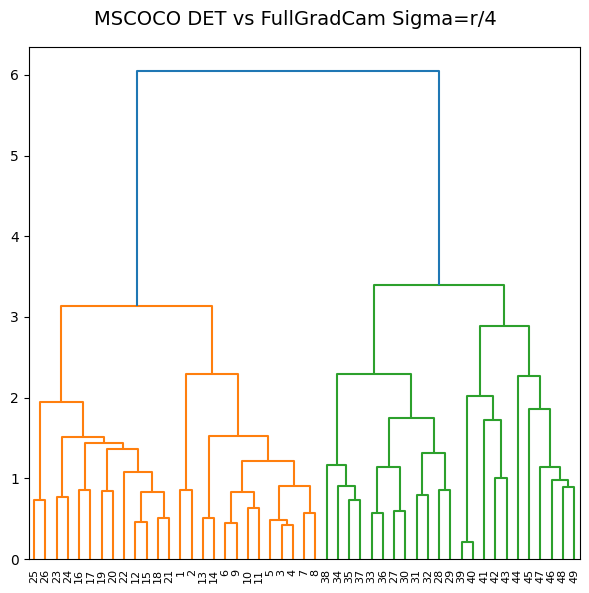

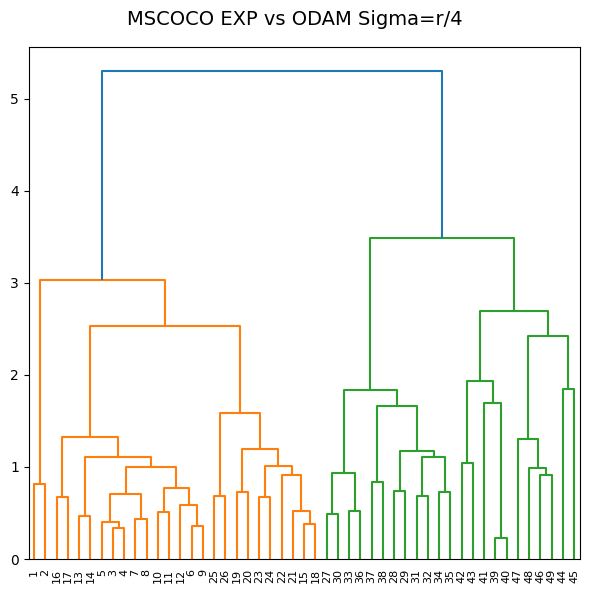

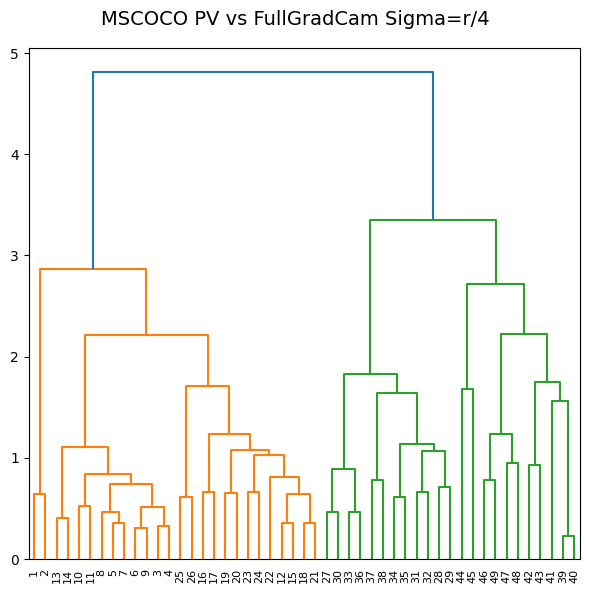

In [13]:
import time, sys

sys.tracebacklimit = 0

def fit_model(ax, analysis, idx, params):

    start = time.time()

    # analysis = 'EXP vs ODAM'
    # data = np.reshape(dfs[analysis].mean(axis=1),(-1, 1))
    nan_imgs = set([dfs[analysis].columns[column] for row,column in zip(*np.where(dfs[analysis].isna()))])
    print(f'{analysis} dropped {len(nan_imgs)}')
    data = dfs[analysis].drop(columns=nan_imgs) #TODO: auto detect and drop nan

    if not params['n_clusters']:
        params['distance_threshold'] = 0 # make sure we compute the full tree

    # try:

    model = AgglomerativeClustering(compute_distances=True,
                                    **params
                                    )
    labels = model.fit_predict(data)
    plot_dendrogram(model, ax=ax,truncate_mode="level", labels=range(1,len(layer_name_mapping)+1))
    # ax.set_title(f"{params['metric']},{params['linkage']}")

    end = time.time()

    res = [{"analysis":analysis,
            **params,
            "labels":labels,
            "distances":model.distances_,
            "time(s)":end-start}]

    return res

    # except Exception:
    #     print(f"Failed to fit {analysis}\t{idx}\t{str(params)}")

    #     end = time.time()

    #     return None

# for analysis in focused_analysis:
#     fig, axs = plt.subplots(nrows=4, ncols=4,figsize=[15,15])
#     idx = 0
#     for params in param_grid:
#         res = fit_model(axs[int(idx/4)][int(idx%4)],analysis,params[0],params[1])
#         if res != None: idx += 1
#     fig.suptitle(f"MSCOCO {analysis}",fontsize=14)
#     plt.tight_layout()
#     plt.draw()

for analysis in focused_analysis:
    fig, axs = plt.subplots(nrows=1, ncols=1,figsize=[6,6])
    idx = 0
    params = param_grid[0]
    res = fit_model(axs,analysis,params[0],params[1])
    if res != None: idx += 1
    fig.suptitle(f"MSCOCO {analysis} Sigma=r/4",fontsize=14)
    plt.tight_layout()
    plt.draw()

##### Membership & Stats Analysis

In [58]:
','.join([str(i) for i in range(1,len(layer_name_mapping)+1)])

'1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49'

In [14]:
membership = {
    'DET vs FullGradCam' : [(25,26,23,24,16,17,19,20,22,12,15,18,21,1,2,13,14,6,9,10,11,5,3,4,7,8),(38,34,35,37,33,36,27,30,31,32,28,29,39,40,41,42,43,44,45,47,46,48,49)],
    'EXP vs ODAM' : [(1,2,16,17,13,14,5,3,4,7,8,10,11,12,6,9,25,26,19,20,23,24,22,21,15,18),(27,30,33,36,37,38,28,29,31,32,34,35,42,43,41,39,40,47,48,46,49,44,45)], 
    'PV vs FullGradCam' : [(1,2,13,14,10,11,8,5,7,6,9,3,4,25,26,16,17,19,20,23,24,22,12,15,18,21),(27,30,33,36,37,38,34,35,31,32,28,29,44,45,46,49,47,48,42,43,41,39,40)]
}

In [18]:
for analysis,groups in membership.items():
    print(analysis)
    max_mean = -1
    max_group = None
    for group in groups:
        inds = [idx-1 for idx in group]
        layers = [layer_name_mapping[idx] for idx in inds]
        mean = PCC_mean[analysis][layers].mean()
        print(f"{mean} {sorted(group)}")
        if mean > max_mean:
            max_mean = mean
            max_group = group
    print(f"{analysis} {sorted(max_group)} {max_mean}")

DET vs FullGradCam
0.38437269603658286 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
0.45983203227057784 [27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
DET vs FullGradCam [27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49] 0.45983203227057784
EXP vs ODAM
0.38035921529279687 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
0.442354147018996 [27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
EXP vs ODAM [27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49] 0.442354147018996
PV vs FullGradCam
0.2582047862395068 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
0.3069510306830268 [27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
PV vs FullGra

In [53]:
PCC_mean[analysis]

backbone.res2.0.conv1               0.130803
backbone.res2.0.conv2               0.139067
backbone.res2.0.conv3               0.165748
backbone.res2.1.conv1               0.172486
backbone.res2.1.conv2               0.168840
backbone.res2.1.conv3               0.147029
backbone.res2.2.conv1               0.170365
backbone.res2.2.conv2               0.109228
backbone.res2.2.conv3               0.106312
backbone.res3.0.conv1               0.167589
backbone.res3.0.conv2               0.171247
backbone.res3.0.conv3               0.172742
backbone.res3.1.conv1               0.168321
backbone.res3.1.conv2               0.163854
backbone.res3.1.conv3               0.173463
backbone.res3.2.conv1               0.159423
backbone.res3.2.conv2               0.155381
backbone.res3.2.conv3               0.165791
backbone.res3.3.conv1               0.164596
backbone.res3.3.conv2               0.105186
backbone.res3.3.conv3               0.111505
backbone.res4.0.conv1               0.171876
backbone.r

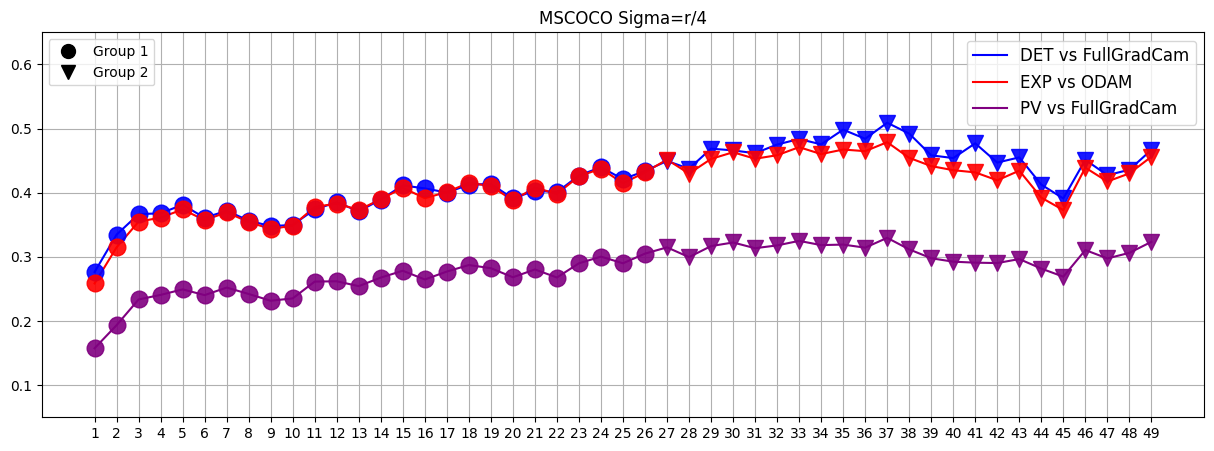

In [17]:
import matplotlib.lines as mlines
# Overall similarity
plt.figure(figsize=(15, 5))
plt.grid()
ax = plt.gca()
# plt.xlabel('Layer')
# plt.ylabel('PCC')
ylims = [0.05,0.65]
for analysis in focused_analysis:
    plt.plot(np.arange(len(PCC_mean[analysis]))+1, list(PCC_mean[analysis]),label=analysis,c=color_code[analysis])
    plt.xticks(np.arange(len(PCC_mean[analysis]))+1, [f"{l+1}" for l,layer in enumerate(layer_name_mapping)]) #rotation=-90
    plt.ylim(ylims)
    # plt.title(f"Yolo-v5s MSCOCO")

legend1 = plt.legend(fontsize=12, loc=0)
ax.add_artist(legend1)

for analysis in focused_analysis:
    # print(labels[analysis])
    for i, group in enumerate(membership[analysis]):
        marker = cluster_labels[i]
        for l in group:
            if l==-1: continue
            layer_name = layer_name_mapping[l-1]
            plt.plot(l,PCC_mean[analysis][layer_name],marker=marker,c=color_code[analysis],markersize=12,alpha=0.9)

    # plt.plot(PCC_mean[analysis].index[12:18].values, PCC_mean[analysis].values[12:18], marker='o',fillstyle='none',label=analysis,c=color_code[analysis],alpha=alpha)

group_markers = []
group1_marker = mlines.Line2D([], [], color='black', marker=cluster_labels[0], linestyle='None',
                          markersize=10, label='Group 1')
group_markers.append(group1_marker)
group2_marker = mlines.Line2D([], [], color='black', marker=cluster_labels[1], linestyle='None',
                          markersize=10, label='Group 2')
group_markers.append(group2_marker)

if len([m for _, m in membership.items() if len(m)>=3])>0:
    group3_marker = mlines.Line2D([], [], color='black', marker=cluster_labels[2], linestyle='None',
                            markersize=10, label='Group 3')
    group_markers.append(group3_marker)

if len([m for _, m in membership.items() if len(m)>=4])>0:
    group4_marker = mlines.Line2D([], [], color='black', marker=cluster_labels[3], linestyle='None',
                              markersize=10, label='Group 4')
    group_markers.append(group4_marker)

legend2=plt.legend(handles=group_markers,loc=2)

plt.title("MSCOCO Sigma=r/4")
plt.show()


In [ ]:
dfs['EXP vs ODAM']

,airplane_167540,airplane_338325,apple_216277,apple_562059,backpack_177065,backpack_370478,banana_279769,banana_290619,baseball bat_129945,baseball bat_270474,...,bowl_578871,cell phone_396729,chair_190236,cup_226171,frisbee_139872,hot dog_400082,knife_227985,microwave_91615,remote_430286,traffic light_133087
1,0.340485,0.487745,0.422461,0.171120,0.345772,0.489412,0.213011,0.069959,0.205886,0.171349,...,0.165028,0.222524,0.453958,0.200256,0.121407,0.284014,0.114572,0.273989,0.244733,0.241762
2,0.407831,0.474527,0.476211,0.197438,0.136220,0.471005,0.201719,0.080534,0.219500,0.221749,...,0.135587,0.167514,0.497294,0.136587,0.180190,0.268800,0.089916,0.294652,0.186271,0.267908
3,0.502018,0.305354,0.390188,0.087370,0.223438,0.412194,0.218753,0.100916,0.230968,0.224781,...,0.088556,0.159146,0.473274,0.168371,0.113323,0.336483,0.106201,0.241494,0.190192,0.298068
4,0.313285,0.451642,0.441561,0.185085,0.149686,0.465566,0.103395,0.065046,0.229736,0.264747,...,0.163333,0.244337,0.663750,0.192314,0.206019,0.355452,0.090651,0.276423,0.292294,0.213033
5,0.289255,0.454263,0.326232,0.127552,0.308027,0.462258,0.126068,0.088343,0.231117,0.267446,...,0.165616,0.185246,0.781867,0.328204,0.212099,0.314308,0.127145,0.328691,0.324099,0.150176
6,0.215859,0.280370,0.350547,0.211686,0.280022,0.621589,0.195192,0.079066,0.135005,0.244733,...,0.270232,0.290181,0.413188,0.228508,0.149321,0.311913,0.117375,0.280837,0.219277,0.124110
7,0.152519,0.410919,0.593986,0.150996,0.470812,0.573490,0.228368,0.128925,0.225542,0.248054,...,0.208053,0.262150,0.260175,0.162156,0.065278,0.177999,0.130981,0.363994,0.225177,0.047461
8,0.500999,0.519226,0.341682,0.160106,0.490370,0.700802,0.165831,0.158943,0.285866,0.254422,...,0.009443,0.280813,0.176864,0.197226,0.134161,0.224033,0.069122,0.164955,0.120590,0.209653
9,0.754912,0.479844,0.346407,0.291272,0.219814,0.679257,0.245526,0.115642,0.267524,0.130083,...,0.175610,0.435229,0.627197,0.299018,0.145760,0.444887,0.038791,0.302417,0.204523,0.226387
10,0.785727,0.544251,0.327291,0.291201,0.684599,0.658434,0.231632,0.109364,0.274061,0.222599,...,0.173914,0.453582,0.619191,0.302816,0.152604,0.436053,0.114152,0.274310,0.196383,0.207739


In [ ]:
def print_ttest(result, df, groups, data):
    print(f"t({df})={np.format_float_positional(result.statistic,precision=3, unique=False, fractional=False, trim='k')}, p={np.format_float_positional(result.pvalue,precision=3, unique=False, fractional=False, trim='k')}")
    print(f"Group {groups[0]}:\n M={np.format_float_positional(np.average(data[0]),precision=3, unique=False, fractional=False, trim='k')}, std={np.format_float_positional(np.std(data[0]),precision=3, unique=False, fractional=False, trim='k')}")
    print(f"Group {groups[1]}:\n M={np.format_float_positional(np.average(data[1]),precision=3, unique=False, fractional=False, trim='k')}, std={np.format_float_positional(np.std(data[1]),precision=3, unique=False, fractional=False, trim='k')}")

from statsmodels.stats.anova import AnovaRM

for analysis in focused_analysis:
    data = dfs[analysis]
    groups = membership[analysis]

    df = []
    for i, group in enumerate(groups):
        for img in data.columns:
            df.append({
                'image': img,
                'group': i+1,
                'value': data.loc[sorted(group)].mean()[img]
            })

    df = pd.DataFrame(df)
    packed = [df[df['group'] == i]['value'] for i, group in enumerate(groups)]

    # paired t test
    if len(groups) == 2:
        print(f"\n{analysis} paired-t test\n")

        result = scipy.stats.ttest_rel(packed[0], packed[1])
        print_ttest(result, len(data.columns)-1, groups, packed)

    elif len(groups) == 3:
        print(f"\n{analysis} Repeated Measures ANOVA test\n")

        anova_results = AnovaRM(df, depvar='value', subject='image', within=['group']).fit()
        print(anova_results.summary())
        
        for i in range(len(groups)):
            for j in range(i+1, len(groups)):
                print(f"Group {i} vs Group {j}")
                result = scipy.stats.ttest_rel(packed[i], packed[j])
                print_ttest(result, len(data.columns)-1, (groups[i],groups[j]), (packed[i],packed[j]))
                print()

    # for jamovi
    df = df.pivot_table(index='image',columns='group',values='value').reset_index()
    df.to_csv(os.path.join('/mnt/h/jinhan/xai/results/clustering/stats/',f"COCO_{analysis.replace(' ','_')}_anova.csv"))



DET vs FullGradCam Repeated Measures ANOVA test

               Anova
      F Value Num DF  Den DF  Pr > F
------------------------------------
group 39.3665 2.0000 286.0000 0.0000

Group 0 vs Group 1
t(143)=-7.57, p=0.00000000000427
Group (4, 5, 3, 1, 2, 8, 6, 7):
 M=0.286, std=0.0842
Group (9, 10):
 M=0.406, std=0.19

Group 0 vs Group 2
t(143)=-5.74, p=0.0000000544
Group (4, 5, 3, 1, 2, 8, 6, 7):
 M=0.286, std=0.0842
Group (13, 11, 12):
 M=0.344, std=0.111

Group 1 vs Group 2
t(143)=4.43, p=0.0000185
Group (9, 10):
 M=0.406, std=0.19
Group (13, 11, 12):
 M=0.344, std=0.111


EXP vs ODAM Repeated Measures ANOVA test

               Anova
      F Value Num DF  Den DF  Pr > F
------------------------------------
group  6.1198 2.0000 286.0000 0.0025

Group 0 vs Group 1
t(143)=-2.86, p=0.00492
Group (4, 5, 3, 1, 2, 8, 6, 7):
 M=0.273, std=0.0959
Group (9, 10):
 M=0.31, std=0.18

Group 0 vs Group 2
t(143)=-1.14, p=0.255
Group (4, 5, 3, 1, 2, 8, 6, 7):
 M=0.273, std=0.0959
Group (13, 11, 1

In [ ]:
df[df['image']=='airplane_167540']

,image,group,value
0,airplane_167540,0,0.342790
144,airplane_167540,1,0.660825


In [ ]:
df.pivot_table(index='image',columns='group',values='value').reset_index()

group,image,0,1
0,airplane_167540,0.342790,0.660825
1,airplane_338325,0.446452,0.459889
2,apple_216277,0.266023,0.293899
3,apple_562059,0.049934,0.045215
4,backpack_177065,0.255896,0.293973
...,...,...,...
139,vase_521282,0.065352,0.023745
140,wine glass_146489,0.083630,0.125491
141,wine glass_25394,0.040817,0.052074
142,zebra_449406,0.263389,0.184806


In [ ]:
p_values = defaultdict()

neck_pcc_all = defaultdict(lambda: defaultdict(list))
backbone_pcc_all = defaultdict(lambda: defaultdict(list))
neck_pcc = defaultdict(list)
backbone_pcc = defaultdict(list)
for analysis, d1 in PCC_all.items():
    print()
    print(analysis)
    for layer, d2 in d1.items():
        for img, pcc in d2.items():
            if layer in range(9,18):
                backbone_pcc_all[analysis][img].append(pcc)
            elif layer in range(5,9):
                neck_pcc_all[analysis][img].append(pcc)

    for img in backbone_pcc_all[analysis].keys():
        backbone_pcc[analysis].append(np.average(backbone_pcc_all[analysis][img]))
        neck_pcc[analysis].append(np.average(neck_pcc_all[analysis][img]))

    result = scipy.stats.ttest_rel(neck_pcc[analysis], backbone_pcc[analysis])
    print(f"t({len(PCC_all[analysis][12]-1)})={np.format_float_positional(result.statistic,precision=3, unique=False, fractional=False, trim='k')}, p={np.format_float_positional(result.pvalue,precision=3, unique=False, fractional=False, trim='k')}")
    print(f"Backbone: M={np.format_float_positional(np.average(backbone_pcc[analysis]),precision=3, unique=False, fractional=False, trim='k')}, std={np.format_float_positional(np.std(backbone_pcc[analysis]),precision=3, unique=False, fractional=False, trim='k')}")
    print(f"Neck: M={np.format_float_positional(np.average(neck_pcc[analysis]),precision=3, unique=False, fractional=False, trim='k')}, std={np.format_float_positional(np.std(neck_pcc[analysis]),precision=3, unique=False, fractional=False, trim='k')}")

    p_values[analysis] = float(np.format_float_positional(result.pvalue,precision=3, unique=False, fractional=False, trim='k'))